In [1]:
%load_ext autoreload
import datetime
# import ete3
import itertools
# import json
import logging
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pm4py
import typing
# import re
import xml.etree.ElementTree as ET
# import xml.dom.minidom
# import xmlschema

In [2]:
%autoreload
from maxes.xes_loader2 import XesLoader, XesLog
# from maxes.xes_file import XesFile
# from maxes.analyze_xes import AnalyzeXes
# import maxes.analyze_sequence
# import maxes.serialization.serialize
# import maxes.graphs
import maxes.notebooks.utils
import maxes.utils

Config:
{'project_directory_path': '/vt/md/maxes/maxes', 'data_directory_path': '/vt/md/maxes/maxes/data'}


In [3]:
maxes.notebooks.utils.init_notebook() # RUN ONLY ONCE

Loading config from: C:\vt\md\maxes\maxes\config.local.yml
Config:
{'project_directory_path': '/vt/md/maxes/maxes', 'data_directory_path': '/vt/md/maxes/maxes/data'}


# Preparation

In [4]:
from maxes.notebooks.utils import get_data_path

log = pm4py.read_xes(get_data_path("other/simple.xes"))

# Filter: only use completed events
log = log[log["lifecycle:transition"] == "complete"]

log

parsing log, completed traces ::   0%|          | 0/3512 [00:00<?, ?it/s]

,call centre,org:resource,time:timestamp,lifecycle:transition,concept:name,case:concept:name,case:description,location,duration,outcome
0,Brisbane,customer,1970-01-01 01:00:00+00:00,complete,incoming claim,0,Simulated process instance,NaN,NaN,NaN
2,NaN,Call Centre Agent Brisbane,1970-01-01 01:00:41+00:00,complete,B check if sufficient information is available,0,Simulated process instance,Brisbane,NaN,NaN
4,NaN,Call Centre Agent Brisbane,1970-01-01 01:12:59+00:00,complete,B register claim,0,Simulated process instance,NaN,NaN,NaN
6,NaN,Claims handler,1970-01-01 01:47:12+00:00,complete,determine likelihood of claim,0,Simulated process instance,NaN,NaN,NaN
8,NaN,Claims handler,1970-01-01 01:47:12+00:00,complete,end,0,Simulated process instance,NaN,2832,not liable
...,...,...,...,...,...,...,...,...,...,...
46129,Sydney,customer,1970-01-01 03:08:09+00:00,complete,incoming claim,999,Simulated process instance,NaN,NaN,NaN
46131,NaN,Call Centre Agent Sydney,1970-01-01 03:35:38+00:00,complete,S check if sufficient information is available,999,Simulated process instance,Sydney,NaN,NaN
46133,NaN,Call Centre Agent Sydney,1970-01-01 03:39:31+00:00,complete,S register claim,999,Simulated process instance,NaN,NaN,NaN
46135,NaN,Claims handler,1970-01-01 07:56:35+00:00,complete,determine likelihood of claim,999,Simulated process instance,NaN,NaN,NaN


# Process mining metrics

This shows usage of common process mining metrics: precision, fitness, generalization

## Good model

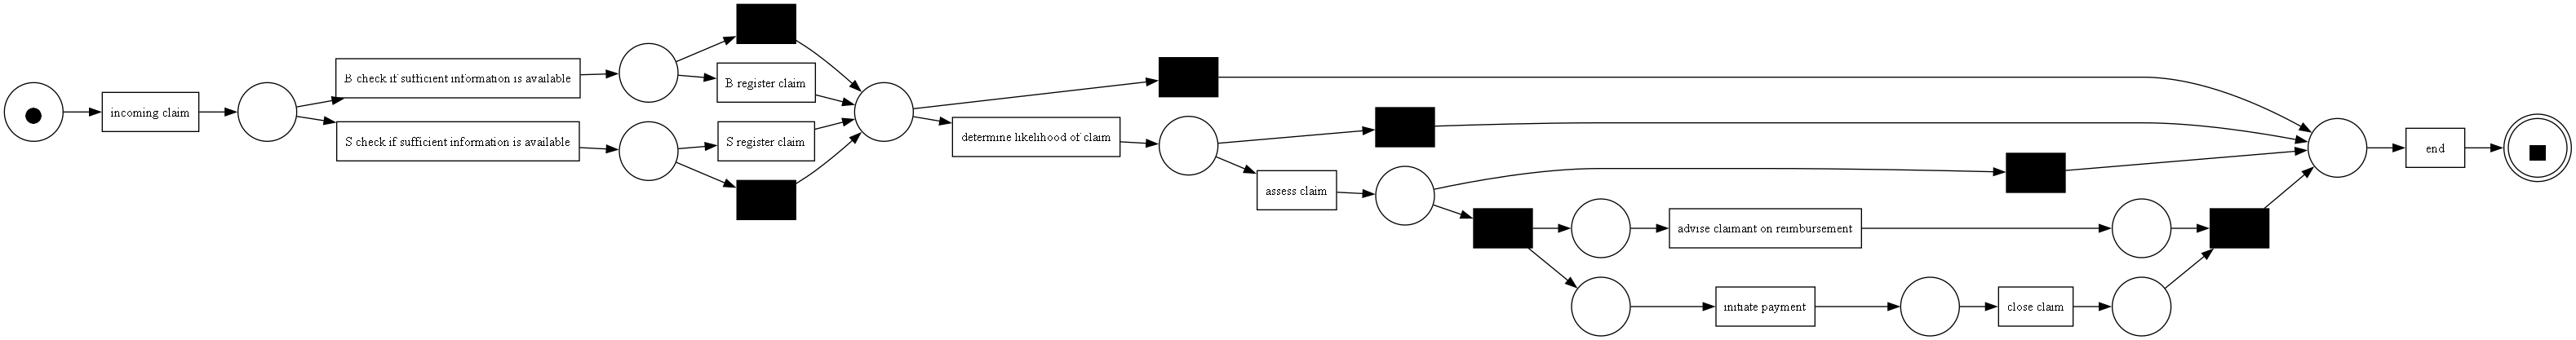

replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

Generalization: 0.969930349495639


replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

Precision:  0.8629916251457649


computing precision with alignments, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

Precision (Alignment-based):  0.8629916251457649


In [5]:
net, im, fm = pm4py.discover_petri_net_inductive(log)

pm4py.view_petri_net(net, im, fm)

print("Fitness: ", pm4py.conformance.fitness_token_based_replay(log, net, im, fm))
print("Generalization:", pm4py.conformance.generalization_tbr(log, net, im, fm))
print("Precision: ", pm4py.conformance.precision_token_based_replay(log, net, im, fm))
print("Precision (Alignment-based): ", pm4py.conformance.precision_alignments(log, net, im, fm))

## Bad model (1)

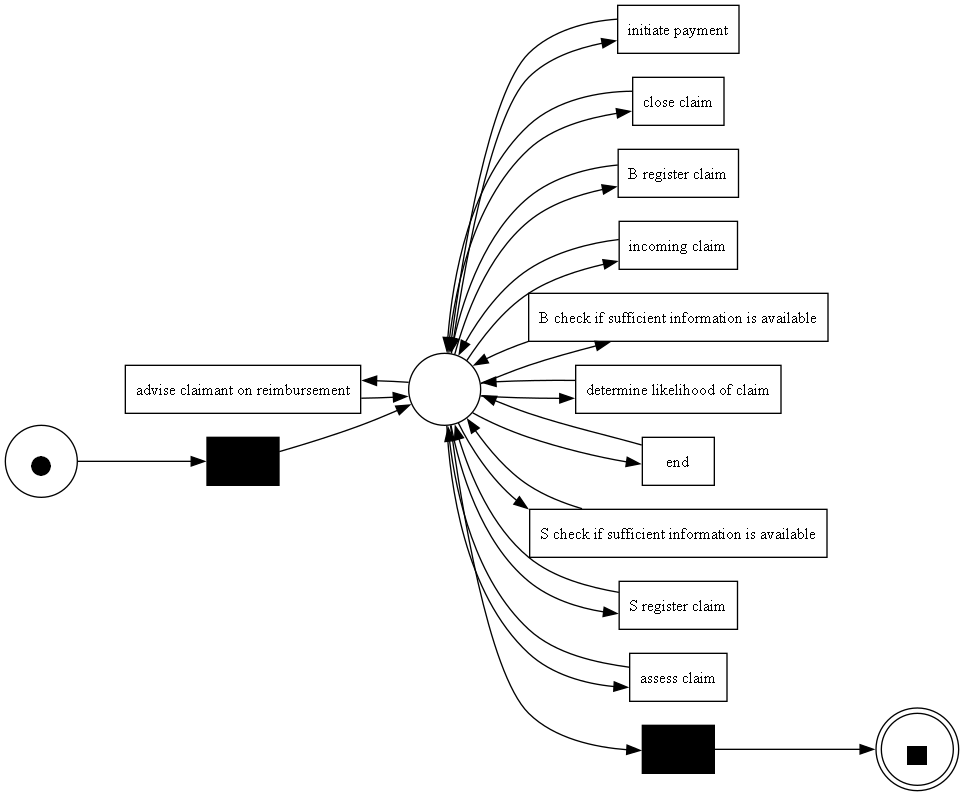

replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

Generalization: 0.9789702148677155


replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

Precision:  0.14905428911471208


In [6]:
import uuid

def add_arc(
        net: pm4py.objects.petri_net.obj.PetriNet,
        source: any,
        destination: any) -> pm4py.objects.petri_net.obj.PetriNet.Arc:
    arc = net.Arc(source, destination)

    net.arcs.add(arc)
    source.out_arcs.add(arc)
    destination.in_arcs.add(arc)

    return arc

def create_generalizing_petri_net(log: pd.DataFrame):
    net = pm4py.PetriNet("X")

    source = net.Place("source")
    net.places.add(source)

    center = net.Place("center")
    net.places.add(center)

    sink = net.Place("sink")
    net.places.add(sink)

    # source -> skip -> center
    skip_1 = net.Transition(name="skip_1")
    net.transitions.add(skip_1)
    add_arc(net, source=source, destination=skip_1)
    add_arc(net, source=skip_1, destination=center)

    # center -> skip -> sink
    skip_2 = net.Transition(name="skip_2")
    net.transitions.add(skip_2)
    add_arc(net, source=center, destination=skip_2)
    add_arc(net, source=skip_2, destination=sink)

    # center <-> event (transition)
    for index, event in enumerate(log["concept:name"].unique()):
        transition = net.Transition(
            name=str(uuid.uuid4()),
            label=event
        )
        net.transitions.add(transition)

        add_arc(net, source=center, destination=transition)
        add_arc(net, source=transition, destination=center)

    # Markings
    im = pm4py.objects.petri_net.obj.Marking([source])
    fm = pm4py.objects.petri_net.obj.Marking([sink])

    return net, im, fm

net, im, fm = create_generalizing_petri_net(log)

pm4py.view_petri_net(net, im, fm)

print("Fitness: ", pm4py.conformance.fitness_token_based_replay(log, net, im, fm))
# print("Fitness (Alignment-based): ", pm4py.conformance.fitness_alignments(log, net, im, fm))
print("Generalization:", pm4py.conformance.generalization_tbr(log, net, im, fm))
print("Precision: ", pm4py.conformance.precision_token_based_replay(log, net, im, fm))
# print("Precision (Alignment-based): ", pm4py.conformance.precision_alignments(log, net, im, fm))

## Bad model (2)

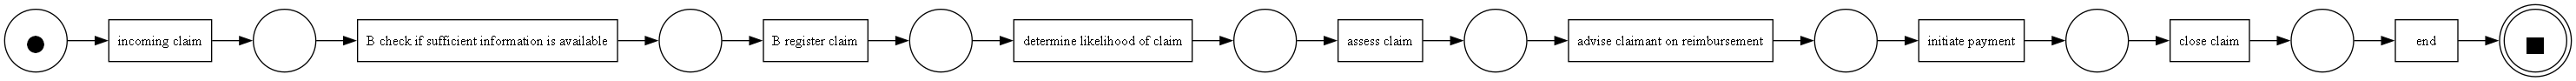

replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 14.94874715261959, 'average_trace_fitness': 0.8038910809198395, 'log_fitness': 0.8430334394904458, 'percentage_of_fitting_traces': 14.94874715261959}


aligning log, completed variants ::   0%|          | 0/12 [00:00<?, ?it/s]

Fitness (Alignment-based):  {'percFitTraces': 14.94874715261959, 'averageFitness': 0.7068938243482696, 'percentage_of_fitting_traces': 14.94874715261959, 'average_trace_fitness': 0.7068938243482696, 'log_fitness': 0.7309907323729024}


replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

Generalization: 0.9789416205930911


replaying log with TBR, completed traces ::   0%|          | 0/25 [00:00<?, ?it/s]

Precision:  0.8198162876666293


computing precision with alignments, completed variants ::   0%|          | 0/25 [00:00<?, ?it/s]

Precision (Alignment-based):  1.0


In [7]:
from collections import Counter

def find_most_frequent_trace_sequence(log: pd.DataFrame) -> list[str]:
    sequences = []

    for _name, df in log.groupby("case:concept:name"):
        sequence = tuple(df["concept:name"])
        sequences.append(sequence)

    c = Counter(sequences)
    return c.most_common(1)[0][0]

def generate_most_frequent_trace_petri_net(log: pd.DataFrame):
    sequence = find_most_frequent_trace_sequence(log)

    net = pm4py.PetriNet("X")

    source = net.Place("source")
    net.places.add(source)

    current_place = source

    for index, event in enumerate(sequence):
        transition = net.Transition(
            name=str(uuid.uuid4()),
            label=event
        )
        net.transitions.add(transition)

        add_arc(net, source=current_place, destination=transition)

        current_place = net.Place(f"p_{index}")
        net.places.add(current_place)

        add_arc(net, source=transition, destination=current_place)

    current_place.name = "sink"

    im = pm4py.objects.petri_net.obj.Marking([source])
    fm = pm4py.objects.petri_net.obj.Marking([current_place])

    return net, im, fm

net, im, fm = generate_most_frequent_trace_petri_net(log)

pm4py.view_petri_net(net, im, fm)

print("Fitness: ", pm4py.conformance.fitness_token_based_replay(log, net, im, fm))
print("Fitness (Alignment-based): ", pm4py.conformance.fitness_alignments(log, net, im, fm))
print("Generalization:", pm4py.conformance.generalization_tbr(log, net, im, fm))
print("Precision: ", pm4py.conformance.precision_token_based_replay(log, net, im, fm))
print("Precision (Alignment-based): ", pm4py.conformance.precision_alignments(log, net, im, fm))

## Usage

In [18]:
import dateutil

net, im, fm = pm4py.discover_petri_net_inductive(log)

# pm4py.view_petri_net(net, im, fm)

In [19]:
generated_log = pd.DataFrame([
    ["0", "incoming claim",                                 "complete", dateutil.parser.isoparse("2024-11-27 00:00:00")],
    ["0", "S check if sufficient information is available", "complete", dateutil.parser.isoparse("2024-11-27 00:10:00")],
    ["0", "B register claim",                               "complete", dateutil.parser.isoparse("2024-11-27 00:20:00")],
    ["0", "invalid event",                                  "complete", dateutil.parser.isoparse("2024-11-27 00:30:00")],
    ["0", "end",                                            "complete", dateutil.parser.isoparse("2024-11-27 00:40:00")],
], columns=["case:concept:name", "concept:name", "lifecycle:transition", "time:timestamp"])

print("Invalid log:")
print("Fitness: ", pm4py.conformance.fitness_token_based_replay(generated_log, net, im, fm))
print("Generalization:", pm4py.conformance.generalization_tbr(generated_log, net, im, fm))
print("Precision: ", pm4py.conformance.precision_token_based_replay(generated_log, net, im, fm))
print("Precision (Alignment-based): ", pm4py.conformance.precision_alignments(generated_log, net, im, fm))

Invalid log:
Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8333333333333334, 'log_fitness': 0.8333333333333334, 'percentage_of_fitting_traces': 0.0}
Generalization: 0.0


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

Precision:  0.33333333333333337


computing precision with alignments, completed variants ::   0%|          | 0/4 [00:00<?, ?it/s]

Precision (Alignment-based):  0.33333333333333337


In [21]:
generated_log = pd.DataFrame([
    ["0", "incoming claim",                                 "complete", dateutil.parser.isoparse("2024-11-27 00:00:00")],
    ["0", "S check if sufficient information is available", "complete", dateutil.parser.isoparse("2024-11-27 00:10:00")],
    ["0", "S register claim",                               "complete", dateutil.parser.isoparse("2024-11-27 00:20:00")],
    ["0", "end",                                            "complete", dateutil.parser.isoparse("2024-11-27 00:40:00")],
    ["1", "incoming claim",                                 "complete", dateutil.parser.isoparse("2024-11-27 00:00:00")],
    ["1", "B check if sufficient information is available", "complete", dateutil.parser.isoparse("2024-11-27 00:10:00")],
    ["1", "B register claim",                               "complete", dateutil.parser.isoparse("2024-11-27 00:20:00")],
    ["1", "end",                                            "complete", dateutil.parser.isoparse("2024-11-27 00:40:00")],
], columns=["case:concept:name", "concept:name", "lifecycle:transition", "time:timestamp"])

print("Invalid log:")
print("Fitness: ", pm4py.conformance.fitness_token_based_replay(generated_log, net, im, fm))
print("Generalization:", pm4py.conformance.generalization_tbr(generated_log, net, im, fm))
print("Precision: ", pm4py.conformance.precision_token_based_replay(generated_log, net, im, fm))
print("Precision (Alignment-based): ", pm4py.conformance.precision_alignments(generated_log, net, im, fm))

Invalid log:


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

Generalization: 0.04881553646890879


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

Precision:  0.625


computing precision with alignments, completed variants ::   0%|          | 0/5 [00:00<?, ?it/s]

Precision (Alignment-based):  0.625


# Other metrics

## Levenstein distance

In [8]:
import Levenshtein

Levenshtein.distance("aaabb", "abbb")

# Steps:
# 1. remove 3rd a:        aaabb -> aabb
# 2. change 2nd a to b:   aabb -> abbb

2

In [9]:
Levenshtein.distance("bab", "abba")

# Steps:
# 1. remove 1st a:        bab -> ab
# 2. add b:               ab  -> abb
# 2. add a:               abb -> abba

3

In [ ]:
import Levenshtein

my_trace_sequence = [
    ["incoming claim",
    ["S check if sufficient information is available",
    ["B register claim",
    ["invalid event",
    ["end",
]

traces = [trace for _caseid, trace in log.groupby("case:concept:name")]

min_distance = min(
    Levenshtein.distance(my_trace_sequence, list(trace["concept:name"]))
    for trace in traces
)
print("Distance:", min_distance)

min_distance_ratio = min(
    Levenshtein.ratio(my_trace_sequence, list(trace["concept:name"]))
    for trace in traces
)
print("Ratio:", min_distance_ratio)

Distance: 2
Ratio: 0.4285714285714286


## EMD

In [ ]:
import scipy.stats

def normal_distribution(lower, upper, mu, sigma, n):
    return scipy.stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(n)


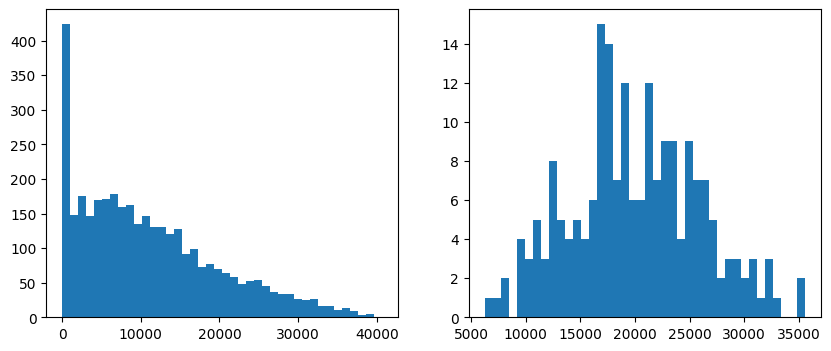

In [ ]:
first_last_timestamps = log.groupby("case:concept:name").aggregate(["first", "last"])["time:timestamp"]
traces_durations = first_last_timestamps["last"] - first_last_timestamps["first"]
traces_durations = [duration.seconds for duration in traces_durations]

generated_durations = normal_distribution(0, 40000, 20000, 6000, 200)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
ax[0].hist(traces_durations, bins=40)
ax[1].hist(generated_durations, bins=40);

In [ ]:
from scipy.stats import wasserstein_distance

wasserstein_distance(
    traces_durations, generated_durations)

np.float64(8877.59686986293)